In [11]:
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt


diabetes_train_splitsize = 1.0

beta_path = None
sum_abs_coeff = None


def fetch_diabetes(subset='train'):
    diabetes = sklearn.datasets.load_diabetes()
    X_all = diabetes.data
    y_all = diabetes.target

    total_N = len(y_all)
    train_N = int(total_N * diabetes_train_splitsize)
    test_N = total_N - train_N
    rand = np.random.mtrand.RandomState(seed=123)
    train_idx = set(rand.choice(total_N, size=(train_N,), replace=False))

    train_X = X_all[list(train_idx)]
    train_y = y_all[list(train_idx)]

    test_idx = np.zeros((test_N,), dtype=np.int32)
    test_n = 0
    for n in range(total_N):
        if n not in train_idx:
            test_idx[test_n] = n
            test_n += 1
    test_X = X_all[test_idx]
    test_y = y_all[test_idx]

    def get_add_mul(X):
        add = - np.average(X, 0)
        X1 = X + add
        mul = 1 / np.sqrt((X1 * X1).sum(0))
        return add, mul

    X_add, X_mul = get_add_mul(train_X)
    y_add = - np.average(train_y)

    train_X = (train_X + X_add) * X_mul
    train_y = train_y + y_add
    if len(test_X) > 0:
        test_X = (test_X + X_add) * X_mul
        test_y = test_y + y_add

    if subset == 'train':
        return sklearn.datasets.base.Bunch(data=train_X, target=train_y)
    elif subset == 'test':
        return sklearn.datasets.base.Bunch(data=test_X, target=test_y)
    else:
        raise Exception('unknown subset %s' % subset)


def vector_len(vector):
    return np.sqrt(np.sum(vector * vector))


def run_lars(train):
    global beta_path, sum_abs_coeff

    X = train.data
    y = train.target
    m = len(X[0])
    n = len(X)

    active_set = set()
    cur_pred = np.zeros((n,), dtype=np.float32)
    residual = y - cur_pred
    cur_corr = X.transpose().dot(residual)
    j = np.argmax(np.abs(cur_corr), 0)
    print('j', j)
    active_set.add(j)
    beta = np.zeros((m,), dtype=np.float32)
    sign = np.zeros((m,), dtype=np.int32)
    sign[j] = 1

    beta_path = np.zeros((m, m), dtype=np.float32)
    for it in range(m):
        residual = y - cur_pred
        mse = np.sqrt(np.sum(residual * residual))
        print('mse', mse)

        pred_from_beta = X.dot(beta)

        cur_corr = X.transpose().dot(residual)

        X_a = X[:, list(active_set)]
        X_a *= sign[list(active_set)]
        G_a = X_a.transpose().dot(X_a)
        G_a_inv = np.linalg.inv(G_a)
        G_a_inv_red_cols = np.sum(G_a_inv, 1)
        A_a = 1 / np.sqrt(np.sum(G_a_inv_red_cols))
        omega = A_a * G_a_inv_red_cols
        equiangular = X_a.dot(omega)  # .reshape(n)

        cos_angle = X.transpose().dot(equiangular)
        gamma = None
        largest_abs_correlation = np.abs(cur_corr).max()
        print('largest_abs_correlation', largest_abs_correlation)
        if it < m - 1:
            next_j = None
            next_sign = 0
            for j in range(m):
                if j in active_set:
                    continue
                v0 = (largest_abs_correlation - cur_corr[j]) / (A_a - cos_angle[j]).item()
                v1 = (largest_abs_correlation + cur_corr[j]) / (A_a + cos_angle[j]).item()
                if v0 > 0 and (gamma is None or v0 < gamma):
                    next_j = j
                    gamma = v0
                    next_sign = 1
                if v1 > 0 and (gamma is None or v1 < gamma):
                    gamma = v1
                    next_j = j
                    next_sign = -1
        else:
            gamma = largest_abs_correlation / A_a

        # coeffs, eg for 3 vectors
        # c_0 * x_0 + c_1 * x_1 + c_2 * x_2 = equiangular
        # we know: x_0, x_1, x_2, equiangular
        # they're all vectors, so equation must hold for each dimension
        # ie, we have equations:
        # c_0 * x_0_0 + c_1 * x_1_0 + c_2 * x_2_0 = equi_0
        # c_0 * x_0_1 + c_1 * x_1_1 + c_2 * x_2_1 = equi_1
        # c_0 * x_0_2 + c_1 * x_1_2 + c_2 * x_2_2 = equi_2
        # ...
        # comparing with doc at
        # https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html#numpy.linalg.solve
        # their x_0, x_1, x_2 is our c_0, c_1, c_2
        # their constants are our x_0_0, ...
        # edit since not square, trying
        # https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html#numpy.linalg.lstsq
        sa = X_a
        sb = equiangular * gamma
        sx = np.linalg.lstsq(sa, sb)
        for i, j in enumerate(active_set):
            beta[j] += sx[0][i] * sign[j]

        print('next j', next_j, 'next sign', next_sign, 'gamma', gamma, 'new max correlation: %s' % (
            largest_abs_correlation - gamma * A_a))

        cur_pred = X.dot(beta)
        active_set.add(next_j)
        sign[next_j] = next_sign

        beta_path[it, :] = beta
        print('beta', beta)

    print('beta_path', beta_path)
    sum_abs_coeff = np.sum(np.abs(beta_path), 1)
    print('sum_abs_coeff', sum_abs_coeff)
    

def run():
    train = fetch_diabetes(subset='train')
    test = fetch_diabetes(subset='test')
    print((train.data * train.data).sum(0))
    print((test.data * test.data).sum(0))
    print(np.average(train.target, 0))
    print(np.average(test.target, 0))
    run_lars(train)


run()

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
-7.71630120282e-15
nan
j 2
mse 1618.95309519
largest_abs_correlation 949.435260384
next j 8 next sign 1 gamma 60.1192696491 new max correlation: 889.315990735
beta [  0.           0.          60.11927032   0.           0.           0.           0.
   0.           0.           0.        ]
mse 1584.44461593
largest_abs_correlation 889.315990434
next j 3 next sign 1 gamma 513.223718805 new max correlation: 452.900968682
beta [   0.            0.          361.8946228     0.            0.            0.
    0.            0.          301.77532959    0.        ]
mse 1303.98189348
largest_abs_correlation 452.900977508
next j 6 next sign -1 gamma 175.553241509 new max correlation: 316.074046695
beta [   0.            0.          434.75796509   79.23645782    0.            0.
    0.            0.          374.91583252    0.        ]
mse 1235.78501888
largest_abs_correlation 316.074050463
next j 1 next sign -1 gamm

/home/ubuntu/.local/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/ubuntu/.local/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


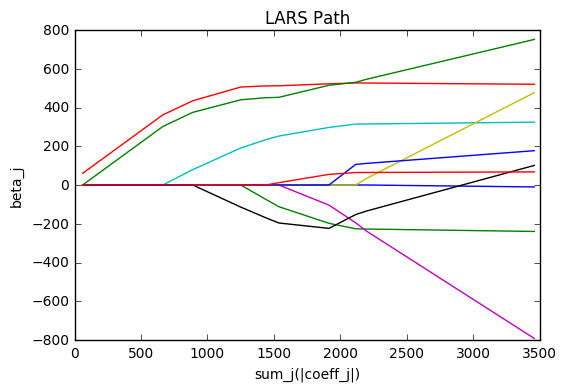

In [10]:
# plotting code is based on:
# http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html
plt.plot(sum_abs_coeff, beta_path)
plt.title('LARS Path')
plt.ylabel('beta_j')
plt.xlabel('sum_j(|coeff_j|)')
plt.show()
